In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [248]:
df = pd.read_csv("Housing3.csv", sep=';')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [250]:
df.shape

(545, 13)

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [254]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [256]:
# checking the unique values
unique_counts = df.nunique()
print("Number of unique values per column:")
print(unique_counts)

Number of unique values per column:
price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64


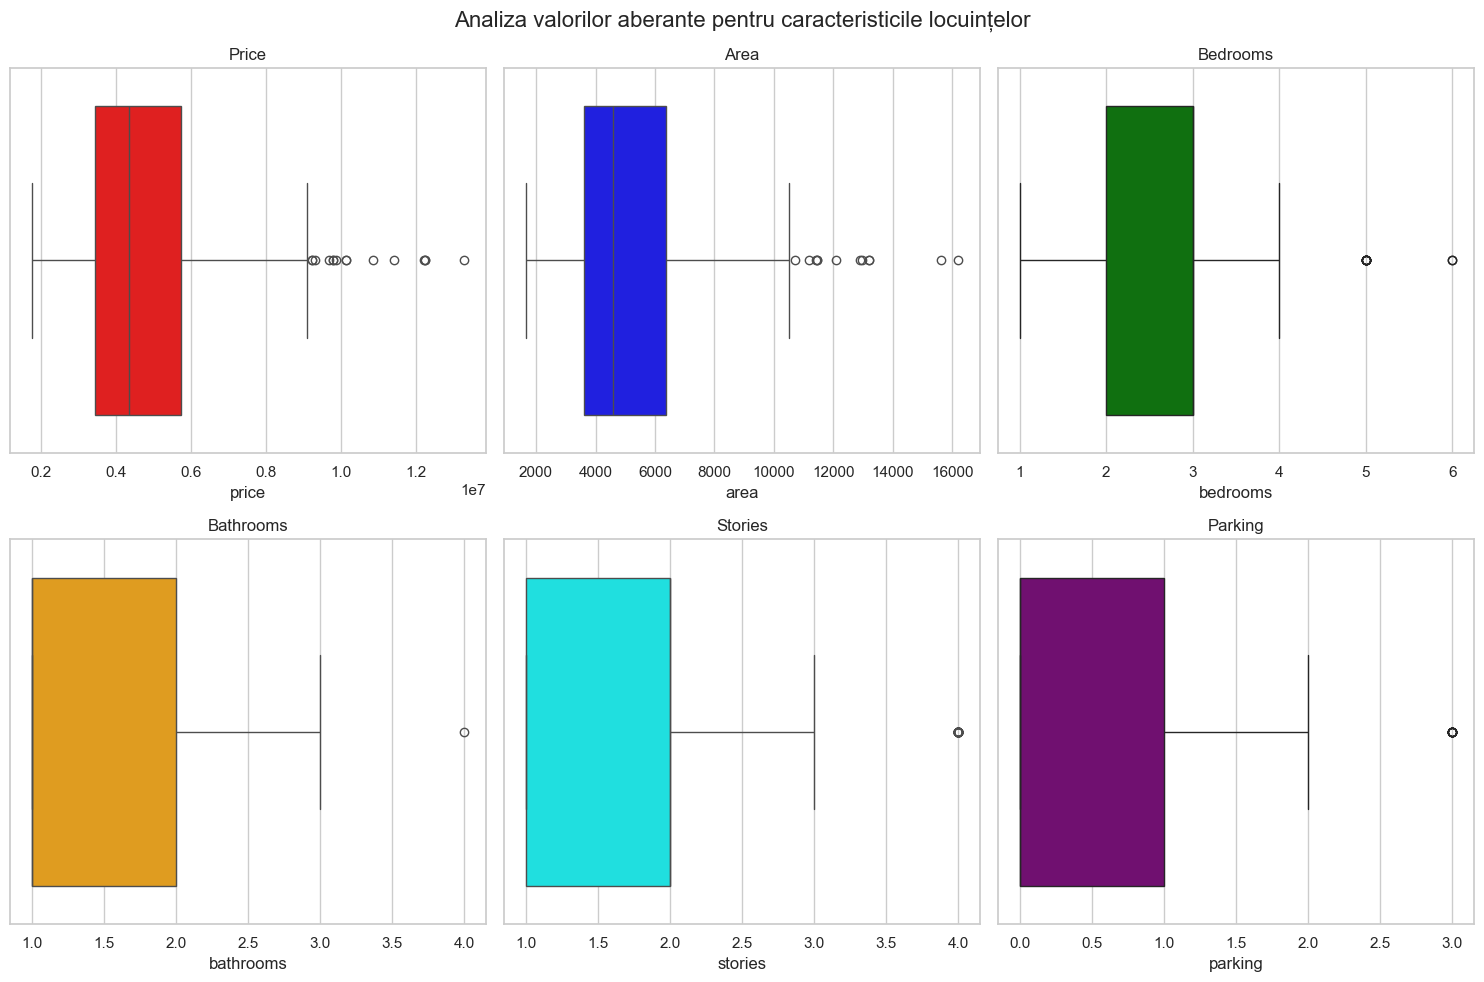

In [258]:
features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
colors = ['red', 'blue', 'green', 'orange', 'aqua', 'purple']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Analiza valorilor aberante pentru caracteristicile locuințelor', fontsize=16)

for (feature, color), ax in zip(zip(features, colors), axes.flatten()):
    sns.boxplot(x=df[feature], color=color, ax=ax)
    ax.set_title(feature.capitalize())

plt.tight_layout()
plt.show()

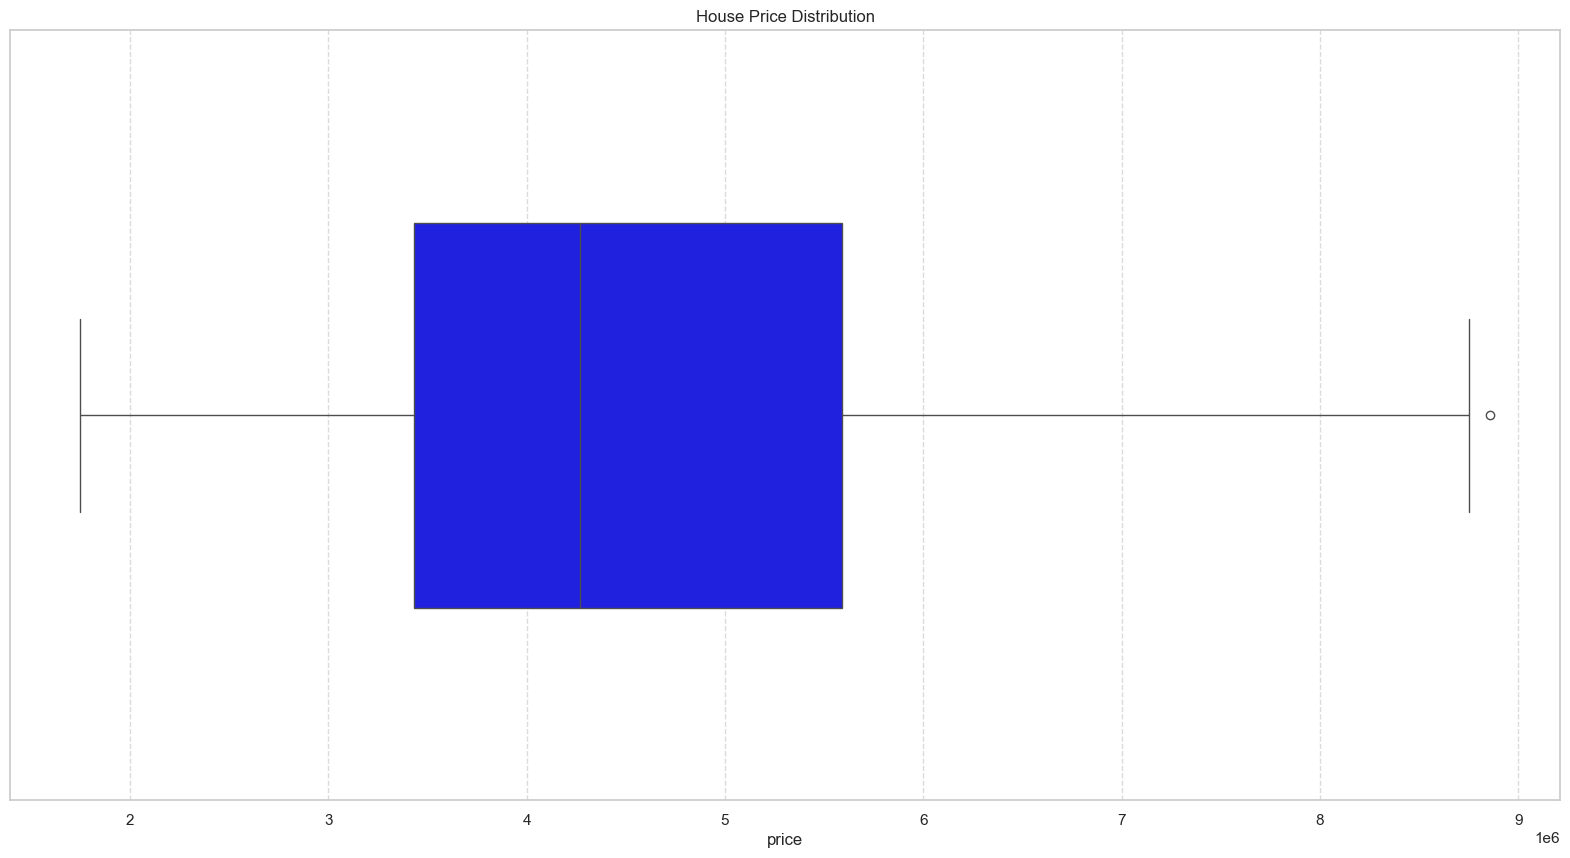

In [264]:
def remove_outliers(df, column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[df[column].between(lower, upper)]

def plot_boxplot(df, column, color, title):
    sns.boxplot(x=df[column], color=color, width=0.5)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Remove outliers for price and plot
df = remove_outliers(df, 'price')
plot_boxplot(df, 'price', 'blue', 'House Price Distribution')

Text(0.5, 1.02, 'Outlier Analysis for Housing Features')

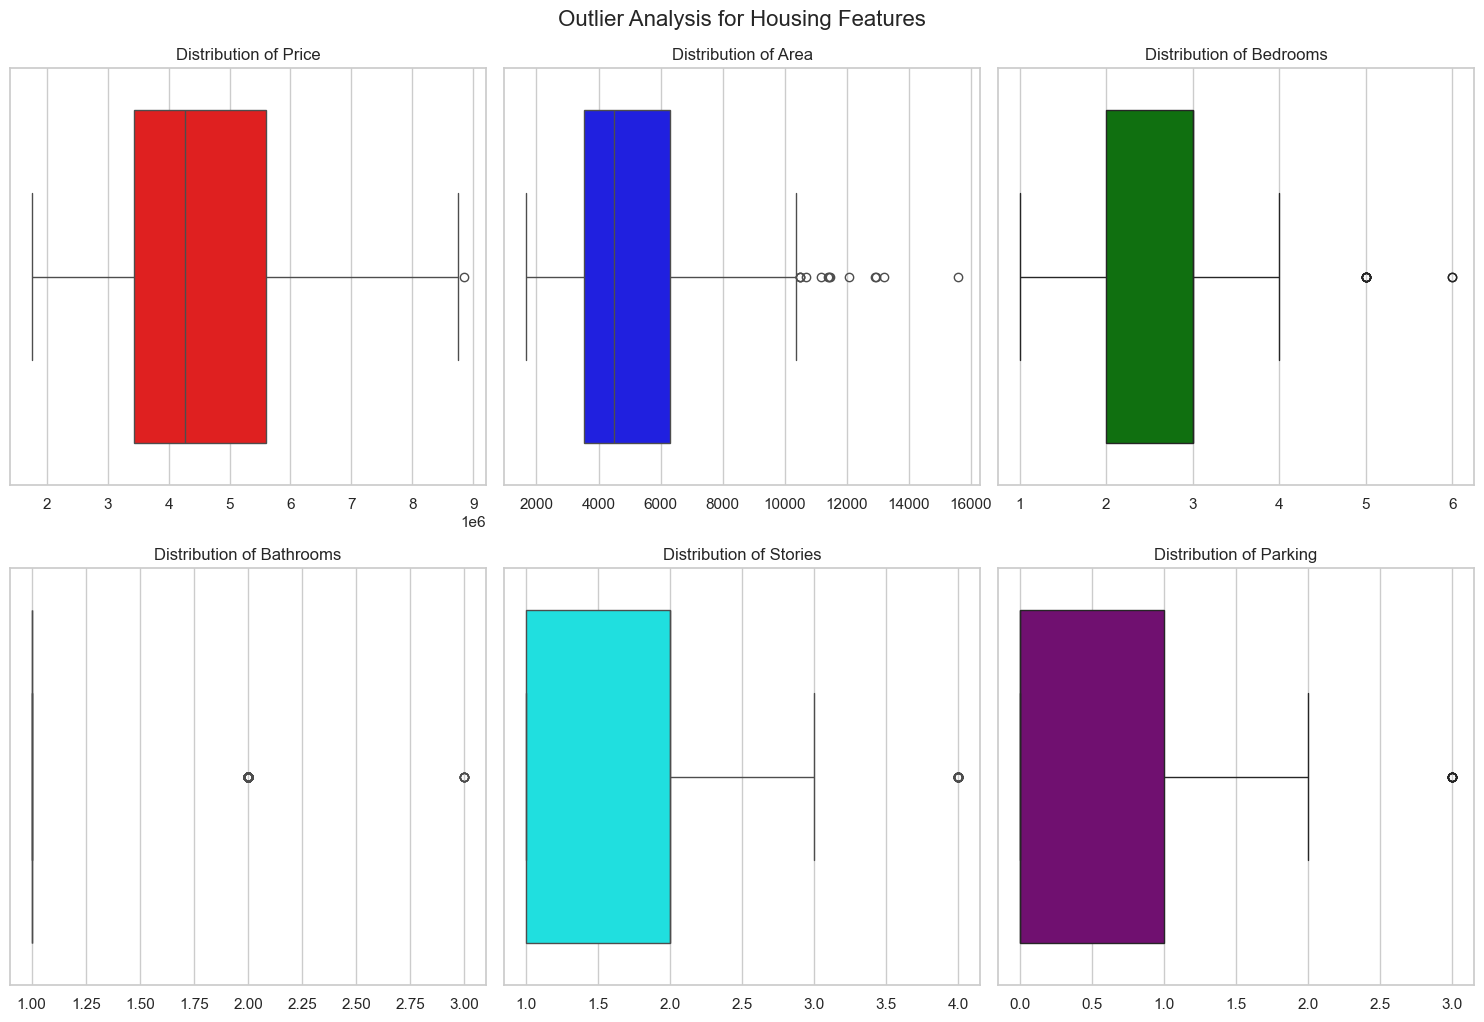

In [266]:
# Outlier Analysis
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
colors = ['red', 'blue', 'green', 'orange', 'aqua', 'purple']

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.boxplot(x=df[feature], ax=axs[row, col], color=colors[i])
    axs[row, col].set_title(f'Distribution of {feature.capitalize()}', fontsize=12)
    axs[row, col].set_xlabel('')

plt.tight_layout()
fig.suptitle('Outlier Analysis for Housing Features', fontsize=16, y=1.02)

In [268]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [270]:
def check_numeric_errors(df, columns):
    high_thresholds = {'price': 1e9, 'area': 100000, 'bedrooms': 10, 'bathrooms': 10, 'stories': 100, 'parking': 10}
    
    for col in columns:
        for condition, label in [(df[df[col] < 0], "Negative"), (df[df[col] == 0], "Zero"), (df[df[col] > high_thresholds.get(col, float('inf'))], "High")]:
            if not condition.empty:
                print(f"\n{label} values in {col}:\n{condition[[col]].head()}")

def check_categorical_errors(df, columns):
    for col in columns:
        unique_values = df[col].unique()
        print(f"{col}: {unique_values[:4]}{'...' if len(unique_values) > 4 else ''}", end="")
        if len(unique_values) > 3:
            print(" - Too many unique values.")

# Run checks
check_numeric_errors(df, ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'])
check_categorical_errors(df, ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'])

print("\n# Error checking complete.")



Zero values in parking:
    parking
26        0
40        0
41        0
45        0
49        0
mainroad: ['yes' 'no']guestroom: ['no' 'yes']basement: ['no' 'yes']hotwaterheating: ['no' 'yes']airconditioning: ['yes' 'no']prefarea: ['yes' 'no']furnishingstatus: ['semi-furnished' 'unfurnished' 'furnished']
# Error checking complete.


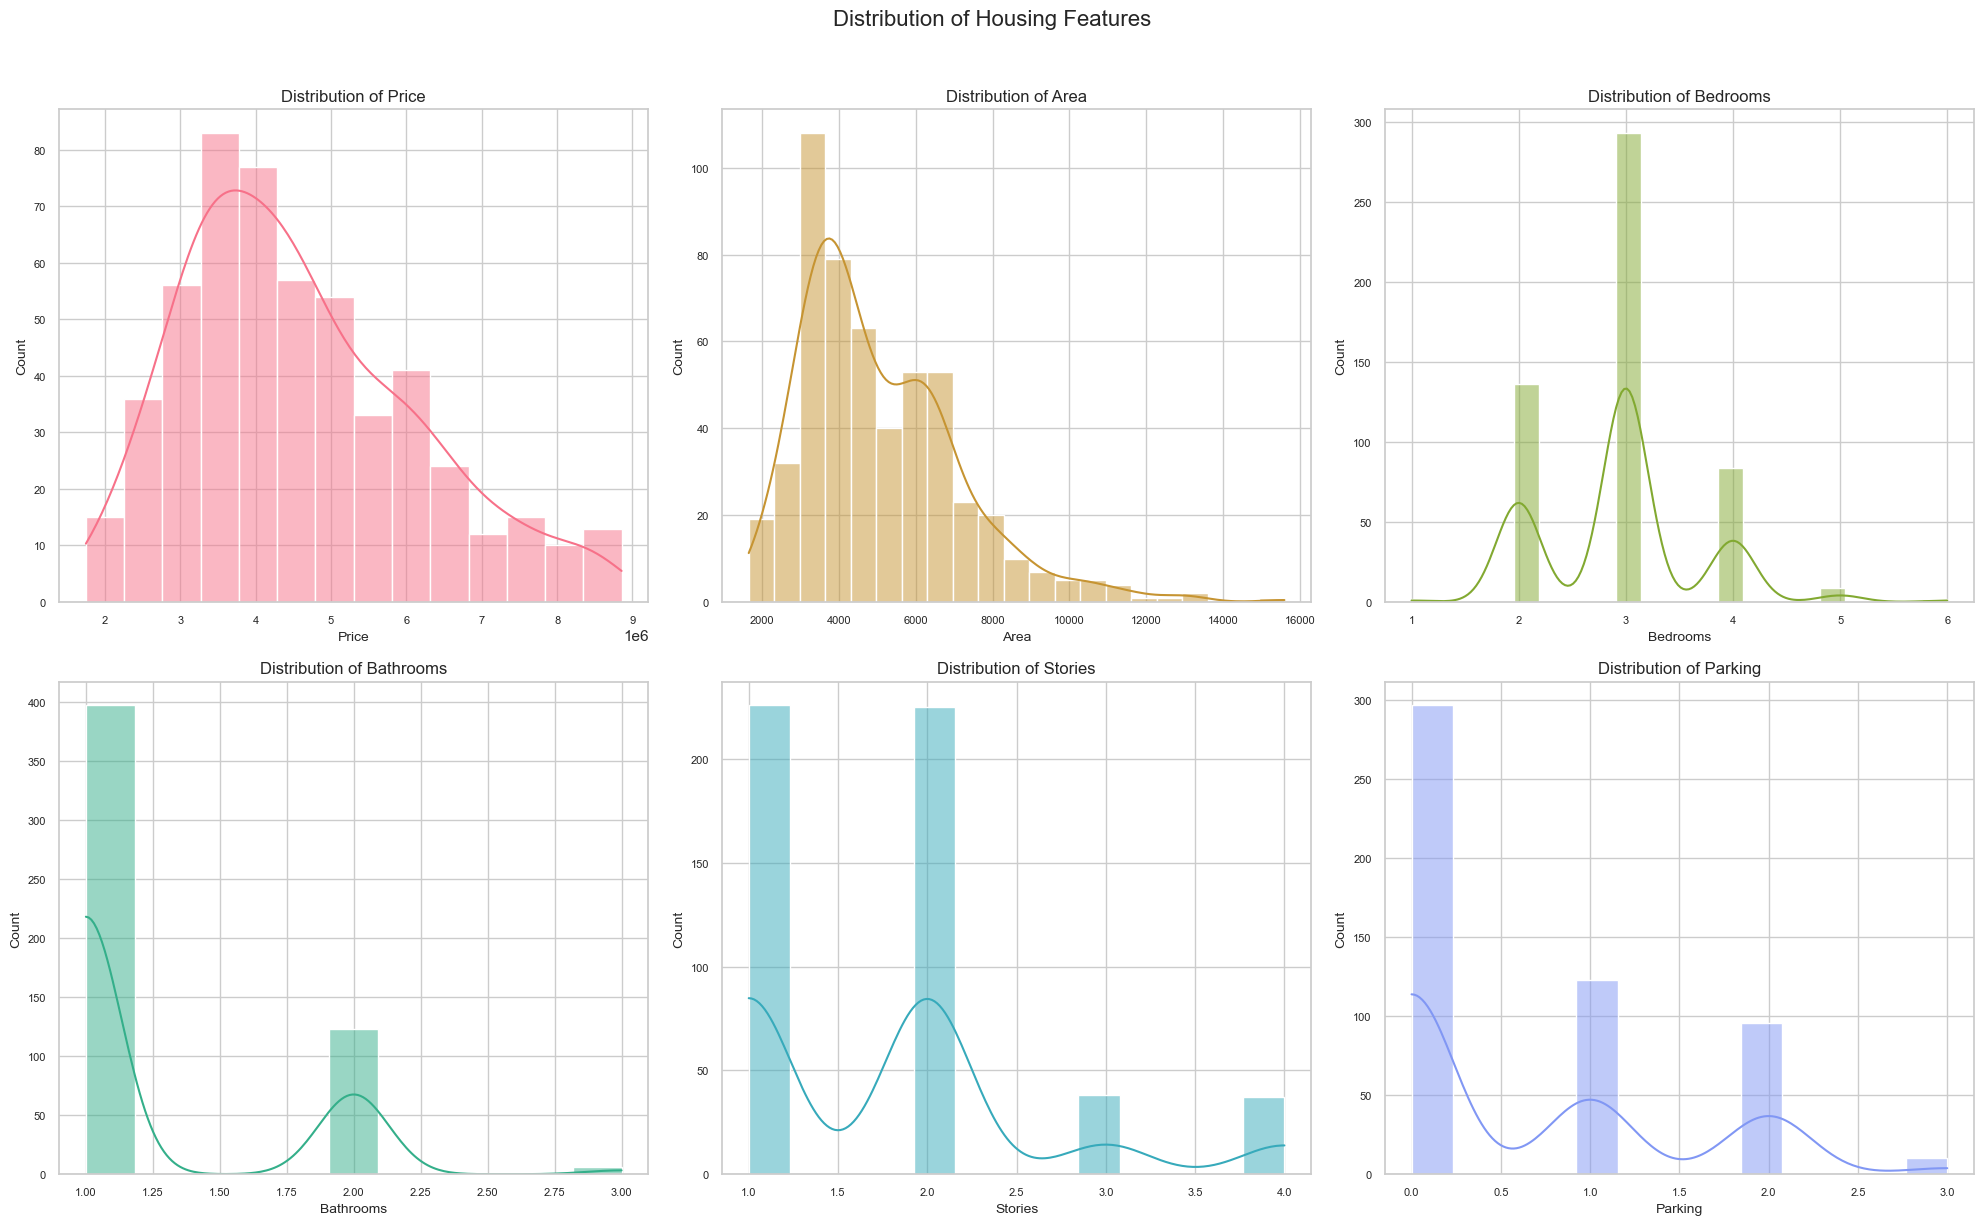

In [272]:
# Visualize distribution using professional histograms
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Housing Features', fontsize=16, y=1.02)

features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
colors = sns.color_palette("husl", 7)

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(data=df, x=feature, kde=True, ax=axs[row, col], color=colors[i])
    axs[row, col].set_title(f'Distribution of {feature.capitalize()}', fontsize=12)
    axs[row, col].set_xlabel(feature.capitalize(), fontsize=10)
    axs[row, col].set_ylabel('Count', fontsize=10)
    axs[row, col].tick_params(labelsize=8)

plt.tight_layout()
plt.show()

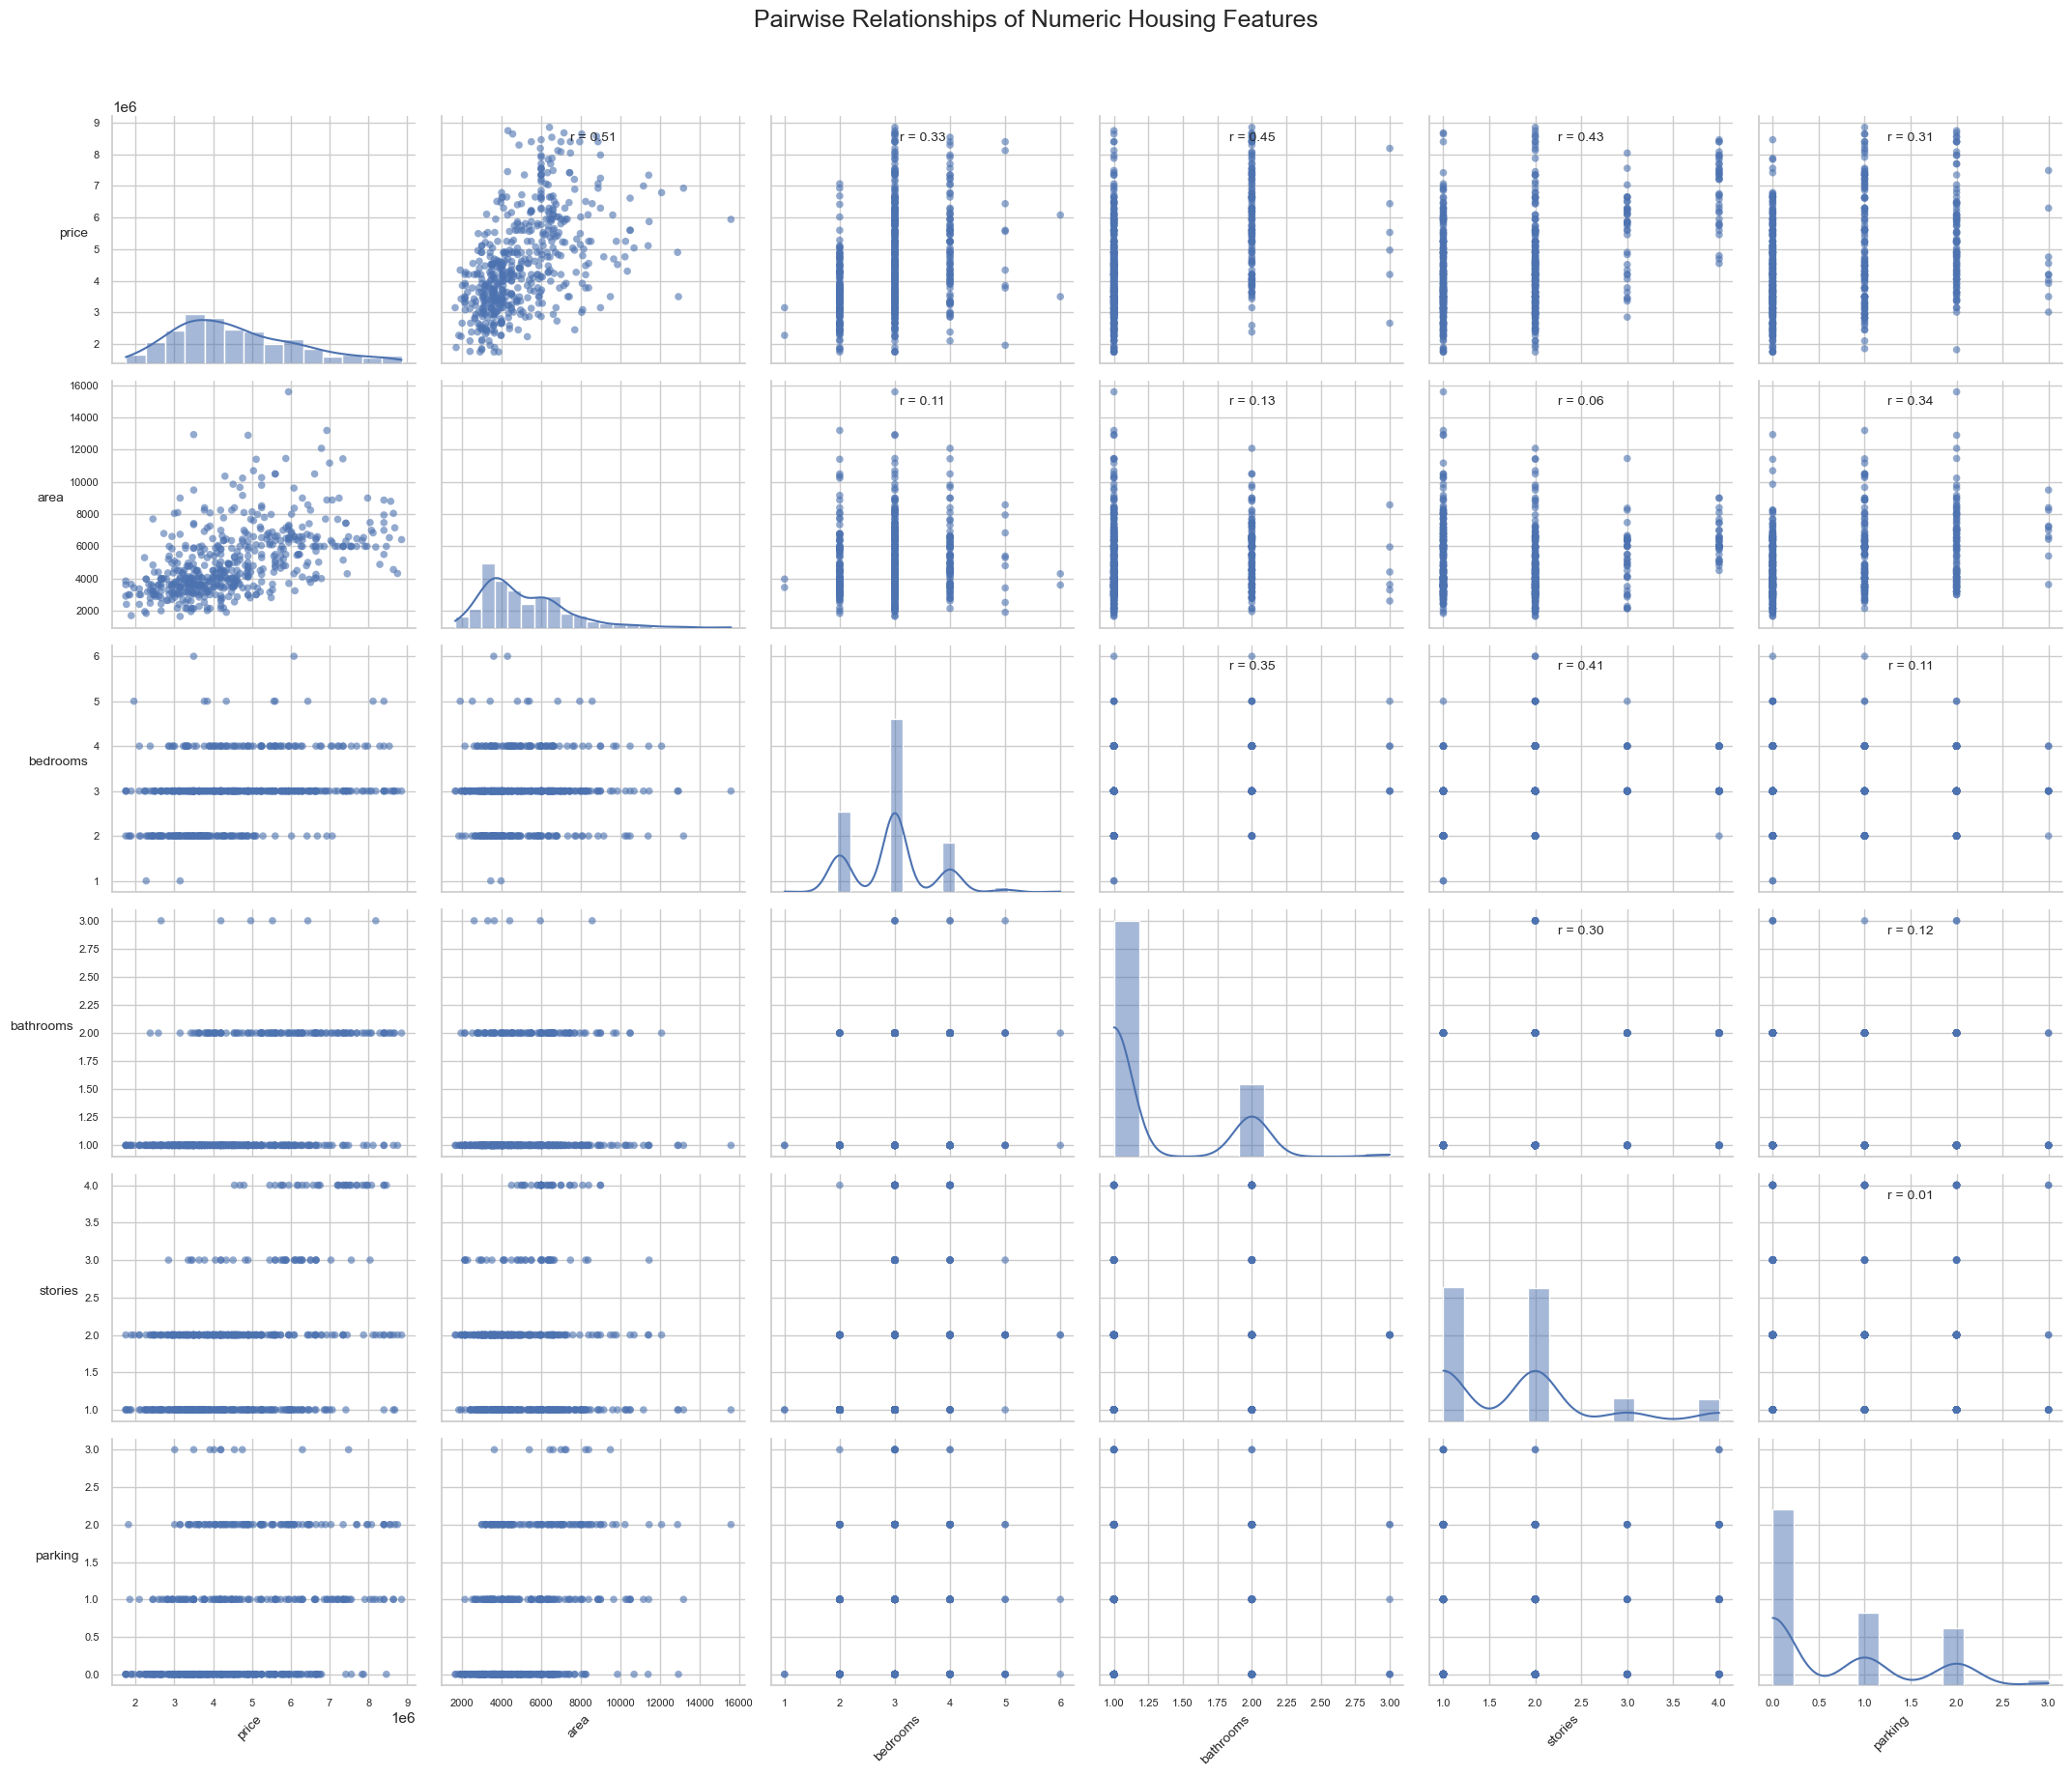

In [274]:
# Set style and palette
sns.set(style="whitegrid", palette="deep")

# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create the pairplot with correlation annotations
g = sns.pairplot(df[numeric_cols], height=3, aspect=1.2, plot_kws={'edgecolor': 'none', 'alpha': 0.6, 's': 30}, diag_kws={'fill': True, 'kde': True})

# Title
g.fig.suptitle("Pairwise Relationships of Numeric Housing Features", y=1.02, fontsize=18)

# Add correlation coefficients to the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    corr = df[numeric_cols[i]].corr(df[numeric_cols[j]])
    g.axes[i, j].annotate(f'r = {corr:.2f}', (0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=10)

# Rotate labels and adjust plot appearance
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

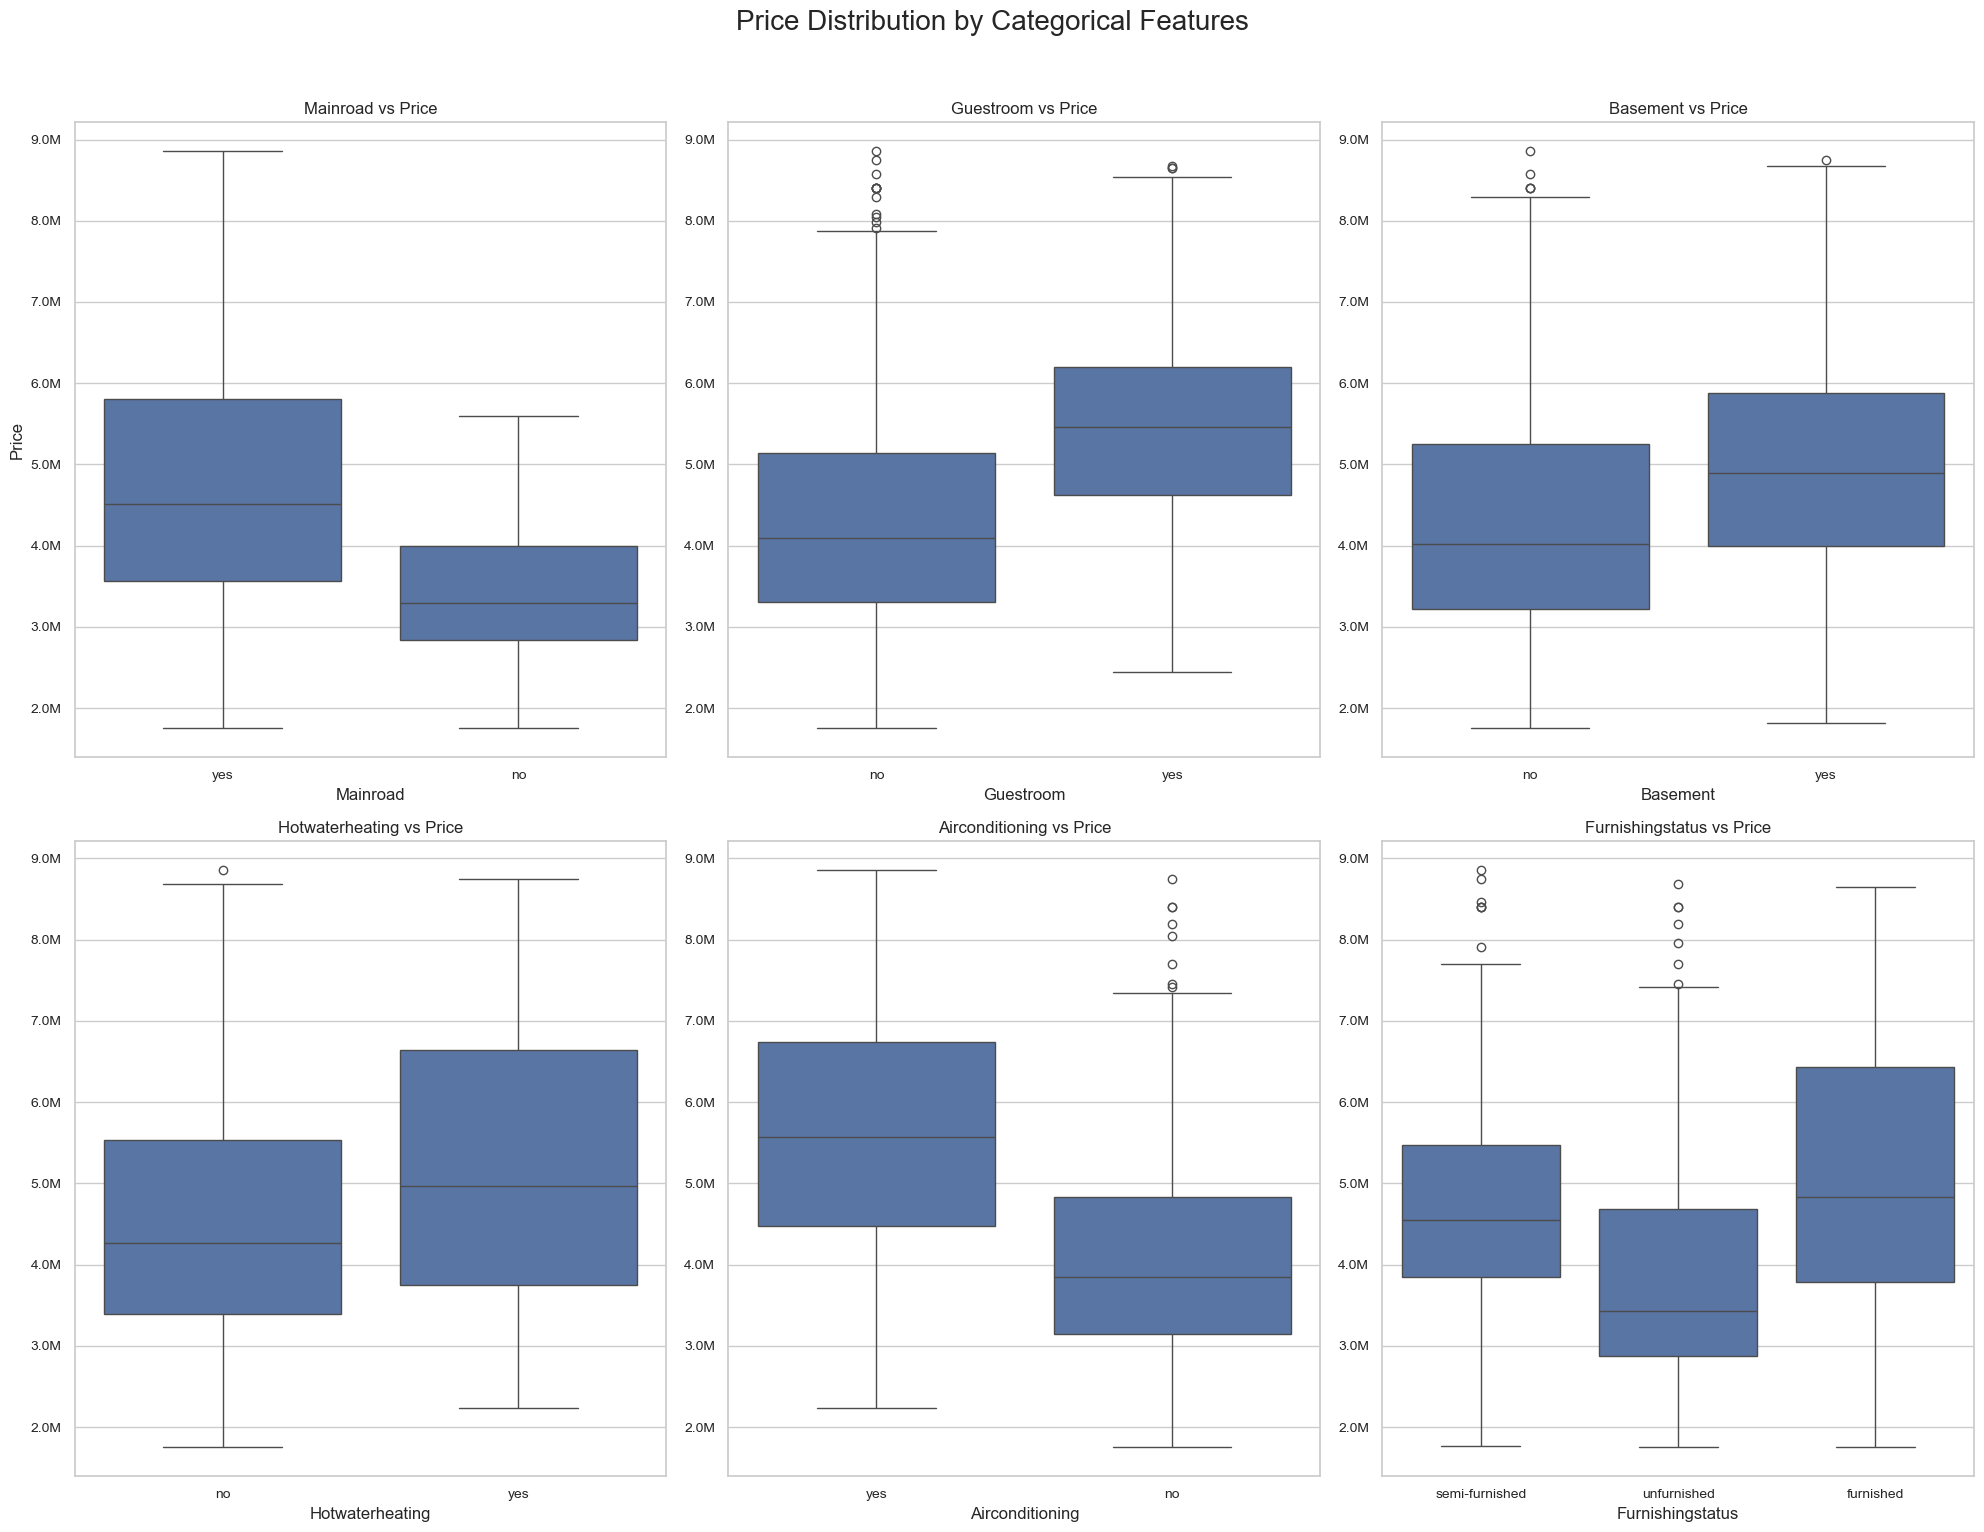

In [276]:
# Set plot style
sns.set_palette("deep")

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Price Distribution by Categorical Features', fontsize=20, y=1.02)

# List of categorical features
cat_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'furnishingstatus']

# Create boxplots
for i, feature in enumerate(cat_features):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=feature, y='price', data=df, ax=ax)
    ax.set(title=f'{feature.capitalize()} vs Price', xlabel=feature.capitalize(), ylabel=('Price' if i == 0 else ''))
    ax.tick_params(labelsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()


In [278]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df, test_size=0.3, random_state=100)

In [280]:
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
115,6020000,8000,3,1,1,yes,yes,yes,no,yes,2,yes,semi-furnished
52,7350000,6000,4,2,4,yes,yes,no,no,yes,1,no,furnished
469,3010000,4600,2,1,1,yes,no,no,no,no,0,no,furnished
148,5600000,6360,3,1,3,yes,no,no,no,no,0,yes,semi-furnished
400,3500000,3512,2,1,1,yes,no,no,no,no,1,yes,unfurnished


In [282]:
# Encode categorical columns in train and test datasets
label_encoders = [LabelEncoder() for col in df_train.select_dtypes(include=['object', 'category']).columns]

for le, col in zip(label_encoders, df_train.select_dtypes(include=['object', 'category']).columns):
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [284]:
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
534,2100000,3000,4,1,2,1,0,0,0,0,0,0,2
485,2870000,3630,2,1,1,1,0,0,0,0,0,0,2
522,2380000,2475,3,1,2,1,0,0,0,0,0,0,0
495,2730000,4000,3,1,2,1,0,0,0,0,1,0,2
319,4060000,3000,4,1,3,1,0,1,0,1,2,0,1


In [292]:
# price
df_train['price'], parameters = stats.boxcox(df_train['price'])
stat, p_value = stats.shapiro(df_train['price'])
print(f'Price is normally distributed.') if (p_value > 0.05) else print(f'Price is not normally distributed.')

# area
df_train['area'], parameters = stats.boxcox(df_train['area'])
stat, p_value = stats.shapiro(df_train['area'])
print(f'Area is normally distributed.') if (p_value > 0.05) else print(f'Area is not normally distributed.')


Price is not normally distributed.
Area is normally distributed.


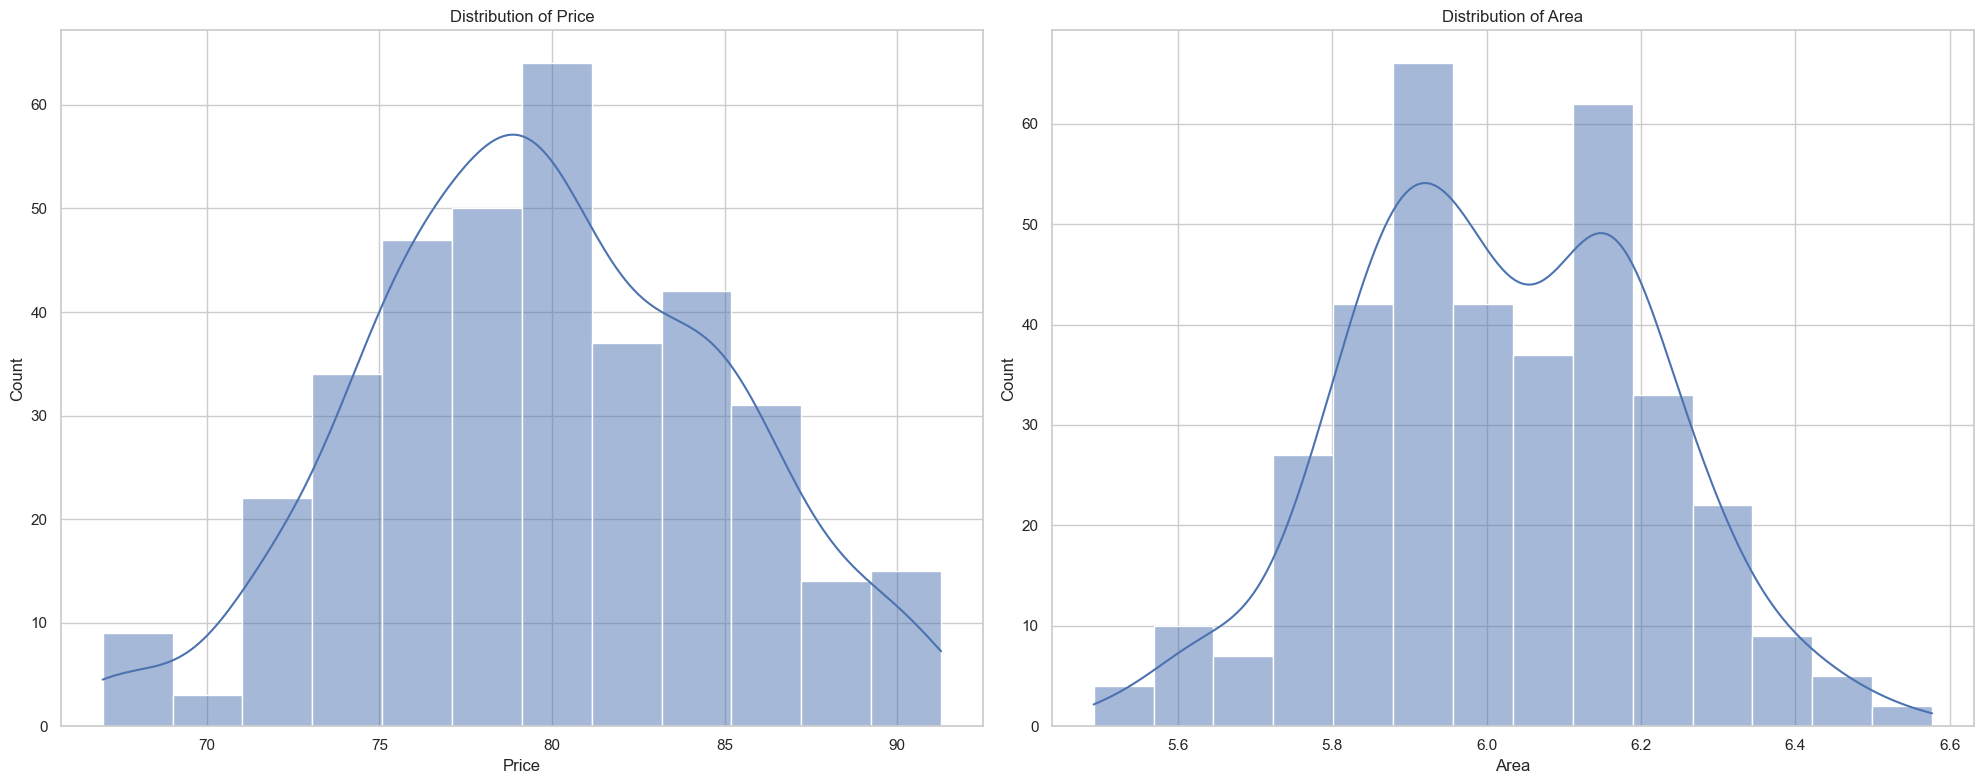

In [294]:
# Visualize the distribution of price and area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(df_train['price'], kde=True, ax=ax1)
ax1.set_title('Distribution of Price')
ax1.set_xlabel('Price')

sns.histplot(df_train['area'], kde=True, ax=ax2)
ax2.set_title('Distribution of Area')
ax2.set_xlabel('Area')

plt.tight_layout()
plt.show()

In [296]:
numerical_features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'furnishingstatus']
scaler = StandardScaler()

df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

In [298]:
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
115,0.993853,1.310355,0.128969,-0.545302,-0.861640,1,1,1,0,1,1.617636,1,-0.078271
52,1.634890,0.616744,1.524873,1.567026,2.535685,1,1,0,0,1,0.417454,0,-1.387523
469,-1.063269,-0.039179,-1.266934,-0.545302,-0.861640,1,0,0,0,0,-0.782727,0,-1.387523
148,0.767168,0.758611,0.128969,-0.545302,1.403243,1,0,0,0,0,-0.782727,1,-0.078271
400,-0.637009,-0.720791,-1.266934,-0.545302,-0.861640,1,0,0,0,0,0.417454,1,1.230982


In [300]:
X = df_train.drop('price', axis=1)
y = df_train['price']

In [302]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [304]:
ridge = Ridge(alpha=12.0)  # You can adjust the alpha value
ridge.fit(X, y)

Ridge(alpha=12.0)

In [310]:
X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

In [312]:
# Making predictions
lm_y_pred = lm.predict(X_test)
ridge_y_pred = ridge.predict(X_test)

# evaluate the model
print("Linear Regression")
print("MSE : ", mean_squared_error(y_test, lm_y_pred))
print("r2 : ", r2_score(y_test, lm_y_pred))

print("\nRidge Regression")
print("MSE : ", mean_squared_error(y_test, ridge_y_pred))
print("r2 : ", r2_score(y_test, ridge_y_pred ))

Linear Regression
MSE :  893649858467.7229
r2 :  -7.836972281901163

Ridge Regression
MSE :  893540047485.9497
r2 :  -7.835886401796127


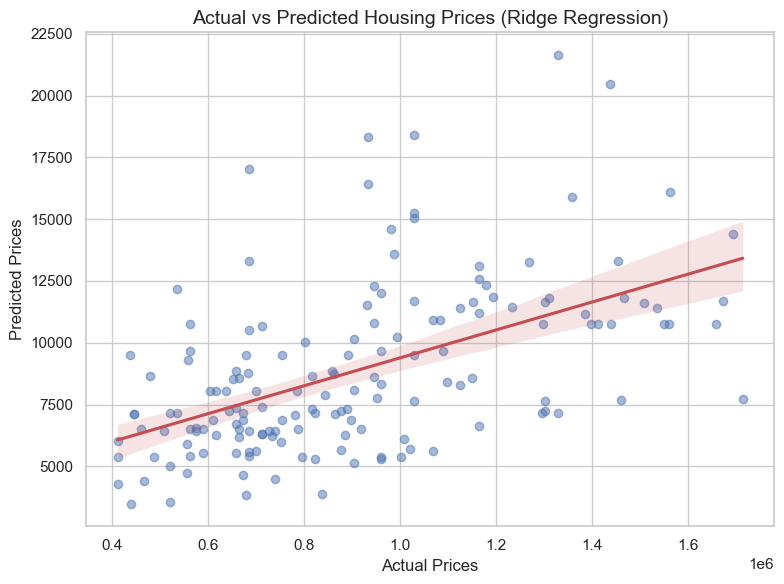

In [314]:
# Visualize Ridge Regression predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=ridge_y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'r'})
plt.title('Actual vs Predicted Housing Prices (Ridge Regression)', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.tight_layout()
plt.show()

In [316]:
# Antrenarea modelului de regresie liniară
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [324]:
# Afișarea coeficienților
coefficients = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
print("Formula pentru regresia liniară este:")
formula = "Price = {:.2f}".format(regressor.intercept_)
for col, coef in zip(X.columns, regressor.coef_):
    formula += " + ({:.2f} * {})".format(coef, col)

print(formula)

Formula pentru regresia liniară este:
Price = -0.55 + (0.35 * area) + (0.06 * bedrooms) + (0.19 * bathrooms) + (0.25 * stories) + (0.23 * mainroad) + (0.10 * guestroom) + (0.27 * basement) + (0.34 * hotwaterheating) + (0.47 * airconditioning) + (0.11 * parking) + (0.41 * prefarea) + (-0.13 * furnishingstatus)
